<br>

# 다중선형회귀분석으로 각 나라의 GDP 순위 예측하기

<br>

#### 저희가 구현할 것은 전세계 각 나라의 1차산업화비중, 도시화율, HDI 등 GDP순위를 결정하는 데 영향을 줄 것으로 보이는 데이터로 가지고 다중 선형회귀 모델로 학습하여 GDP순위를 예측하는 프로그램입니다. 

---

### 사용한 데이터 출처
1차 산업화 비중 : https://stats.oecd.org/Index.aspx?DataSetCode=AEO11_COUNTRYNOTES_TAB2_EN<br>
도시화율 : https://data.worldbank.org/indicator/SP.URB.TOTL.IN.ZS <br>
Human development index (HDI) : http://hdr.undp.org/en/content/human-development-index-hdi<br>
나라별 1인당 GDP : https://data.worldbank.org/indicator/SP.URB.TOTL.IN.ZS 



<br>

## 데이터 분석하기

---

파일을 확인하기 위해 파일을 읽는 **pandas** 를 불러온 다음 데이터 파일을 불러오겠습니다.

In [1]:
from pandas.io.parsers import read_csv
data = read_csv('Data for wealth ranking.csv', sep=',', encoding='cp949')

데이터를 확인해 보겠습니다.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4043 entries, 0 to 4042
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   COUNTRY             4043 non-null   object 
 1   YEAR                4043 non-null   int64  
 2   1차산업비중              4043 non-null   float64
 3   도시화율                4043 non-null   float64
 4   HDI                 4043 non-null   float64
 5   GDP_rank_percapita  4043 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 189.6+ KB


보시면 변수로 나라, 연도, 1차산업비중, 도시화율, 인간개발지수(HDI), 그리고 나라별 GDP 순위를 확인할 수 있습니다. 총 데이터의 수는 4043개로 학습하기에 충분한 양입니다. 
이 중 연도, 1차산업비중, 도시화율, HDI 4가지 변수를 독립 변수로 설정하고 나라별 GDP 순위를 종속 변수로 설정하여 학습을 진행하겠습니다.
<br><br>

---


다음으로 데이터의 조건을 알아보겠습니다. <br>
모든 데이터를 머신러닝에 활용할 수는 없습니다. 게다가 저희가 사용할 선형회귀는 고전적 선형회귀 모델로 사용할 데이터에 더욱 다양한 조건들이 붙습니다.<br> 그 조건들에 대해 간단히 알아보겠습니다. <br>

**1. 회귀분석은 오직 정량적인 데이터에만 적용할 수 있다.** <br>
변수들이 실제 단위를 가지고 있고, 의미를 가지는 숫자가 아니라면 회귀분석은 경향을 파악하는 데에 좋은 방법은 아닐수도 있습니다.<br><br><br>
**2. 선형성 가정 (Assumption of Linearity)** <br>
선형성은 선형 회귀분석에서만 해당되는 조건입니다. 회귀선은 데이터가 어느 정도 선형을 띄지 않는다면 굉장히 잘못된 결과를 알려줄 수도 있습니다.

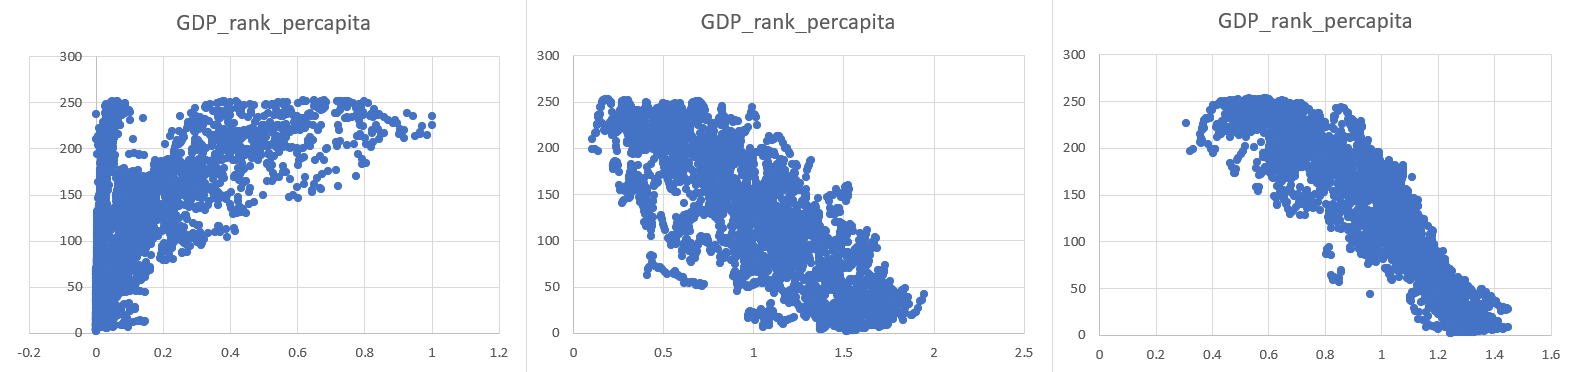

In [3]:
import PIL.Image as pilimg
graph = pilimg.open('graph.png')
graph

데이터의 선형성을 확인할 수 있는 간단한 방법은 산점도를 확인하는 것입니다. 위의 이미지를 보시면 왼쪽부터 차례대로 1차산업비중, 도시화율, 인간개발지수(HDI)와 그에 따른 나라별 GDP 순위를 나타낸 것입니다. 보시는 바와 같이 선형으로 데이터의 분포가 모여있는 것을 확인할 수 있습니다.<br><br><br>
**3. 이상치가 없어야 합니다.** <br>
이상치 하나가 회귀분석을 진행할 때 회귀직선과 상관 계수에 엄청난 영향을 줄 수 있습니다. 저희 데이터에서는 뚜렷하게 보이는 이상치는 없어보입니다.<br><br>
그 외에도 조건들이 있지만 저희가 사용할 데이터에는 해당하지 않으니 넘어가도록 하겠습니다.<br><br><br>

---


그럼, 다음으로 변수간의 상관 관계를 알아 보겠습니다.<br>
먼저, 데이터를 차트나 플롯(Plot)으로 그려주는 **matplotlib**와<br> 
다양한 색상 테마와 통계용 차트 등의 기능을 추가시켜주는 **seaborn**을 불러 오겠습니다.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

히트맵은 X축과 Y축에 2개의 범주형 자료의 계급(class)별로 색깔을 다르게 해서 2차원으로 자료를 시각화하는 도구입니다. 이것을 통해 데이터의 상관 관계를 쉽게 알아볼 수 있습니다.

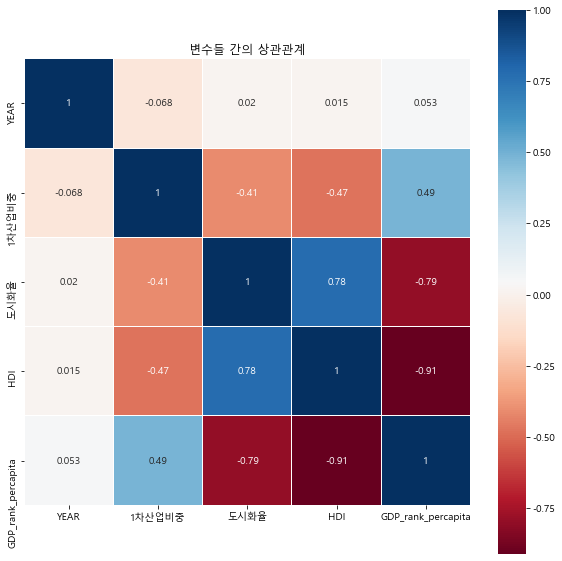

In [5]:
#한글 폰트를 사용 가능
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False


plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), linewidths=0.01, square=True,
            annot=True, cmap='RdBu', linecolor="white")
plt.title('변수들 간의 상관관계')
plt.show()

히트맵을 보시면 각각의 칸 안에는 변수의 상관정도를 수치로 나타냅니다.
보통 데이터간의 상관계수가 0.8을 넘으면 다중공선성을 의심할 수 있습니다. 다중공선성이란 회귀 분석에서 일부 독립 변수가 다른 독립 변수와 상관 정도가 높아 데이터 분석 시 부정적인 영향을 미치는 현상을 말합니다. <br>
이 중 GDP는 독립 변수가 아닌 종속 변수로 GDP와 관련된 상관관계는 신경 쓰지 않아도 됩니다. 독립 변수 간의 상관 정도 중 눈여겨볼 만한 것은 도시화율과 HDI의 상관정도입니다. 0.78로 꽤 높은 값을 가지고 있지만 일단 0.8을 넘지 않았고, 꼭 넣어야 할 변수를 제거할 수 없으니 그 관계만 파악하고 넘어가겠습니다.

## 데이터 학습하기

---

현재 데이터의 가장 첫 열에는 나라의 이름이 들어가있습니다. 

In [6]:
data.head()

,COUNTRY,YEAR,1차산업비중,도시화율,HDI,GDP_rank_percapita
0,Afghanistan,2002,5.196173,0.405800,0.580645,245
1,Afghanistan,2003,5.033535,0.405131,0.589041,247
2,Afghanistan,2004,3.998039,0.405432,0.603318,248
3,Afghanistan,2005,4.185529,0.406662,0.612855,249
4,Afghanistan,2006,3.852073,0.407920,0.619822,248


학습에 필요한 행렬에는 숫자값만 들어가야해서 나라를 제거한 데이터를 가져오겠습니다. (연도는 기존의 변수로 생각은 안했지만 넣는 것이 정확도 향상에 도움이 되어 넣도록 하겠습니다.)

In [7]:
data = read_csv('test data.csv', sep=',')
data.head()

,YEAR,1차산업비중,도시화율,HDI,GDP_rank_percapita
0,2002,5.196173,0.405800,0.580645,245
1,2003,5.033535,0.405131,0.589041,247
2,2004,3.998039,0.405432,0.603318,248
3,2005,4.185529,0.406662,0.612855,249
4,2006,3.852073,0.407920,0.619822,248


예측모델의 성능을 확인하기 위해 **sklearn** 라이브러리의 train_test_split을 사용하여 데이터를 분할할 수도 있지만 <br>
저희는 데이터를 몇 개 선정하여 직접 확인해보겠습니다.

그럼 임의의 값을 선정하기 위해 우선 데이터를 셔플링해주고 가장 위에 있는 값들을 나중에 확인해보겠습니다.<br>
나중에 확인할 수 있게 저장해두겠습니다.

In [8]:
import pandas as pd
from sklearn.utils import shuffle
data = shuffle(data)

dataframe = pd.DataFrame(data.head())
dataframe.to_csv("data image.csv", mode = 'w')

data.head()

,YEAR,1차산업비중,도시화율,HDI,GDP_rank_percapita
388,2014,1.851047,0.770953,0.988858,149
1979,2010,0.207620,1.597668,1.272597,46
1790,2013,0.007706,1.709417,1.284712,40
1506,2005,1.986833,0.960188,1.053812,169
3970,2004,0.128434,0.511566,0.710407,201


<br><br>
그럼 이제 학습을 시켜보겠습니다. 머신러닝 학습을 위한 tensorflow와 계산을 하는 numpy를 불러옵니다.

In [9]:
import tensorflow as tf
import numpy as np

그 다음 모델을 초기화해주고 학습을 위해 행렬의 형태로 만들어줍니다.

In [10]:
model = tf.global_variables_initializer()
xy = np.array(data, dtype=np.float32)

이제 독립변수와 종속변수를 나누어주겠습니다.

In [11]:
x_data = xy[5:, :-1]
y_data = xy[5:, [-1]]

x_data와 y_data를 위한 placeholder를 만들고, 가중치와 편향의 변수도 초기화하여 만들어 줍니다.

In [12]:
X = tf.placeholder(tf.float32, shape=[None, 4])
Y = tf.placeholder(tf.float32, shape=[None, 1])
W = tf.Variable(tf.random_normal([4, 1]), name="weight")
b = tf.Variable(tf.random_normal([1]), name="bias")

실제 가설식을 세워줍니다. 가장 기본적인 행렬의 곱을 이용한 선형회귀 모델입니다. <br>
실제 Y값과 가설식의 결과값의 차이를 나타내는 비용함수도 설정해줍니다.

In [13]:
hypothesis = tf.matmul(X, W) + b
cost = tf.reduce_mean(tf.square(hypothesis - Y))

이제 최적화함수를 설정해줄건데, 먼저 저희가 배운 경사하강법을 사용하여 실행해보겠습니다.  

In [14]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.00000005)
train = optimizer.minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(200001):
    cost_, hypo_, _ = sess.run([cost, hypothesis, train], feed_dict={X : x_data, Y : y_data})
    if step%500 == 0:
        print("#", step, "손실 비용: ", cost_)
        print("-GDP순위: ", hypo_[0])

# 0 손실 비용:  12045678.0
-GDP순위:  [3610.717]
# 500 손실 비용:  5177.203
-GDP순위:  [130.43723]
# 1000 손실 비용:  5176.8765
-GDP순위:  [130.43398]
# 1500 손실 비용:  5176.552
-GDP순위:  [130.43071]
# 2000 손실 비용:  5176.227
-GDP순위:  [130.42747]
# 2500 손실 비용:  5175.9023
-GDP순위:  [130.42421]
# 3000 손실 비용:  5175.577
-GDP순위:  [130.42094]
# 3500 손실 비용:  5175.2524
-GDP순위:  [130.4177]
# 4000 손실 비용:  5174.9297
-GDP순위:  [130.41444]
# 4500 손실 비용:  5174.604
-GDP순위:  [130.41118]
# 5000 손실 비용:  5174.279
-GDP순위:  [130.40794]
# 5500 손실 비용:  5173.956
-GDP순위:  [130.40468]
# 6000 손실 비용:  5173.6304
-GDP순위:  [130.40143]
# 6500 손실 비용:  5173.3066
-GDP순위:  [130.3982]
# 7000 손실 비용:  5172.982
-GDP순위:  [130.39493]
# 7500 손실 비용:  5172.6567
-GDP순위:  [130.39168]
# 8000 손실 비용:  5172.3345
-GDP순위:  [130.38843]
# 8500 손실 비용:  5172.01
-GDP순위:  [130.38518]
# 9000 손실 비용:  5171.685
-GDP순위:  [130.38193]
# 9500 손실 비용:  5171.3604
-GDP순위:  [130.37868]
# 10000 손실 비용:  5171.0376
-GDP순위:  [130.37543]
# 10500 손실 비용:  5170.7134
-GDP순위:  [130.37216]
# 1

# 89000 손실 비용:  5120.604
-GDP순위:  [129.86574]
# 89500 손실 비용:  5120.2886
-GDP순위:  [129.86255]
# 90000 손실 비용:  5119.974
-GDP순위:  [129.85934]
# 90500 손실 비용:  5119.6616
-GDP순위:  [129.85614]
# 91000 손실 비용:  5119.3447
-GDP순위:  [129.85297]
# 91500 손실 비용:  5119.031
-GDP순위:  [129.84975]
# 92000 손실 비용:  5118.718
-GDP순위:  [129.84654]
# 92500 손실 비용:  5118.4023
-GDP순위:  [129.84334]
# 93000 손실 비용:  5118.0884
-GDP순위:  [129.84015]
# 93500 손실 비용:  5117.7744
-GDP순위:  [129.83694]
# 94000 손실 비용:  5117.461
-GDP순위:  [129.83376]
# 94500 손실 비용:  5117.146
-GDP순위:  [129.83055]
# 95000 손실 비용:  5116.8315
-GDP순위:  [129.82735]
# 95500 손실 비용:  5116.5166
-GDP순위:  [129.82416]
# 96000 손실 비용:  5116.204
-GDP순위:  [129.82092]
# 96500 손실 비용:  5115.8896
-GDP순위:  [129.81775]
# 97000 손실 비용:  5115.576
-GDP순위:  [129.81456]
# 97500 손실 비용:  5115.2617
-GDP순위:  [129.81134]
# 98000 손실 비용:  5114.9487
-GDP순위:  [129.80817]
# 98500 손실 비용:  5114.634
-GDP순위:  [129.80495]
# 99000 손실 비용:  5114.3213
-GDP순위:  [129.80174]
# 99500 손실 비용:  5114.0

# 176500 손실 비용:  5066.3394
-GDP순위:  [129.30927]
# 177000 손실 비용:  5066.0327
-GDP순위:  [129.30609]
# 177500 손실 비용:  5065.7266
-GDP순위:  [129.30296]
# 178000 손실 비용:  5065.4214
-GDP순위:  [129.29979]
# 178500 손실 비용:  5065.115
-GDP순위:  [129.29662]
# 179000 손실 비용:  5064.8086
-GDP순위:  [129.29346]
# 179500 손실 비용:  5064.5034
-GDP순위:  [129.2903]
# 180000 손실 비용:  5064.1978
-GDP순위:  [129.28712]
# 180500 손실 비용:  5063.8916
-GDP순위:  [129.28395]
# 181000 손실 비용:  5063.5845
-GDP순위:  [129.28079]
# 181500 손실 비용:  5063.281
-GDP순위:  [129.27765]
# 182000 손실 비용:  5062.977
-GDP순위:  [129.2745]
# 182500 손실 비용:  5062.6733
-GDP순위:  [129.27138]
# 183000 손실 비용:  5062.3716
-GDP순위:  [129.26822]
# 183500 손실 비용:  5062.0674
-GDP순위:  [129.2651]
# 184000 손실 비용:  5061.7646
-GDP순위:  [129.26196]
# 184500 손실 비용:  5061.4624
-GDP순위:  [129.25883]
# 185000 손실 비용:  5061.16
-GDP순위:  [129.25569]
# 185500 손실 비용:  5060.8564
-GDP순위:  [129.25256]
# 186000 손실 비용:  5060.5547
-GDP순위:  [129.24942]
# 186500 손실 비용:  5060.2515
-GDP순위:  [129.2463]
#

보시면 손실비용이 5000대 근처에서 머물러 있는 걸 볼 수 있습니다. 경사하강법은 stepsize가 일정하여 항상 같은 크기로 변화하기 때문에 아무리 epoch의 크기를 늘려 반복학습을 하여도 변화의 폭이 크지 않습니다. 그래서 저희는 보다 안정적으로 최적화를 위한 하강이 가능하고  stepsize를 과거의 gradient 크기를 참고하여 조절하는 adam함수를 사용하였습니다.

In [15]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01,beta1=0.9,beta2=0.999)
train = optimizer.minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(200001):
    cost_, hypo_, _ = sess.run([cost, hypothesis, train], feed_dict={X : x_data, Y : y_data})
    if step%500 == 0:
        print("#", step, "손실 비용: ", cost_)
        print("-GDP순위: ", hypo_[0])

# 0 손실 비용:  9043787.0
-GDP순위:  [-2885.5176]
# 500 손실 비용:  5086.5986
-GDP순위:  [128.93637]
# 1000 손실 비용:  5047.204
-GDP순위:  [129.01038]
# 1500 손실 비용:  4990.433
-GDP순위:  [128.38841]
# 2000 손실 비용:  4915.339
-GDP순위:  [127.54898]
# 2500 손실 비용:  4820.7803
-GDP순위:  [126.463005]
# 3000 손실 비용:  4705.882
-GDP순위:  [125.096985]
# 3500 손실 비용:  4570.626
-GDP순위:  [123.417496]
# 4000 손실 비용:  4416.3584
-GDP순위:  [121.39705]
# 4500 손실 비용:  4246.13
-GDP순위:  [119.02108]
# 5000 손실 비용:  4064.6338
-GDP순위:  [116.29465]
# 5500 손실 비용:  3877.6318
-GDP순위:  [113.24804]
# 6000 손실 비용:  3690.9329
-GDP순위:  [109.93994]
# 6500 손실 비용:  3509.173
-GDP순위:  [106.45785]
# 7000 손실 비용:  3334.7898
-GDP순위:  [102.91514]
# 7500 손실 비용:  3167.4917
-GDP순위:  [99.44225]
# 8000 손실 비용:  3004.6343
-GDP순위:  [96.16684]
# 8500 손실 비용:  2842.748
-GDP순위:  [93.178894]
# 9000 손실 비용:  2679.7395
-GDP순위:  [90.49141]
# 9500 손실 비용:  2516.2595
-GDP순위:  [88.029366]
# 10000 손실 비용:  2355.061
-GDP순위:  [85.672806]
# 10500 손실 비용:  2199.3184
-GDP순위:  [83.32378]


# 89500 손실 비용:  752.8201
-GDP순위:  [43.272034]
# 90000 손실 비용:  752.8162
-GDP순위:  [43.273003]
# 90500 손실 비용:  752.8126
-GDP순위:  [43.280327]
# 91000 손실 비용:  752.909
-GDP순위:  [42.955647]
# 91500 손실 비용:  752.8047
-GDP순위:  [43.270958]
# 92000 손실 비용:  752.8011
-GDP순위:  [43.27387]
# 92500 손실 비용:  752.79724
-GDP순위:  [43.265427]
# 93000 손실 비용:  752.79395
-GDP순위:  [43.250443]
# 93500 손실 비용:  752.9682
-GDP순위:  [42.850994]
# 94000 손실 비용:  752.7857
-GDP순위:  [43.27613]
# 94500 손실 비용:  752.7819
-GDP순위:  [43.27598]
# 95000 손실 비용:  752.77814
-GDP순위:  [43.279816]
# 95500 손실 비용:  752.77435
-GDP순위:  [43.275818]
# 96000 손실 비용:  752.8294
-GDP순위:  [43.033504]
# 96500 손실 비용:  755.48706
-GDP순위:  [44.931435]
# 97000 손실 비용:  752.7629
-GDP순위:  [43.27719]
# 97500 손실 비용:  752.7592
-GDP순위:  [43.260296]
# 98000 손실 비용:  752.7553
-GDP순위:  [43.276695]
# 98500 손실 비용:  752.7517
-GDP순위:  [43.278866]
# 99000 손실 비용:  752.7479
-GDP순위:  [43.28028]
# 99500 손실 비용:  752.7443
-GDP순위:  [43.25758]
# 100000 손실 비용:  754.2216
-GDP순위:  [

# 177500 손실 비용:  752.17175
-GDP순위:  [43.25319]
# 178000 손실 비용:  752.16174
-GDP순위:  [43.37356]
# 178500 손실 비용:  752.47943
-GDP순위:  [43.909176]
# 179000 손실 비용:  752.1572
-GDP순위:  [43.40157]
# 179500 손실 비용:  752.15027
-GDP순위:  [43.356922]
# 180000 손실 비용:  752.1461
-GDP순위:  [43.344353]
# 180500 손실 비용:  752.14246
-GDP순위:  [43.341007]
# 181000 손실 비용:  752.1389
-GDP순위:  [43.34123]
# 181500 손실 비용:  752.1353
-GDP순위:  [43.342148]
# 182000 손실 비용:  752.13184
-GDP순위:  [43.35383]
# 182500 손실 비용:  752.129
-GDP순위:  [43.312637]
# 183000 손실 비용:  752.1247
-GDP순위:  [43.32644]
# 183500 손실 비용:  752.1207
-GDP순위:  [43.34477]
# 184000 손실 비용:  752.1172
-GDP순위:  [43.33685]
# 184500 손실 비용:  752.11865
-GDP순위:  [43.415554]
# 185000 손실 비용:  752.1106
-GDP순위:  [43.372288]
# 185500 손실 비용:  752.1451
-GDP순위:  [43.542397]
# 186000 손실 비용:  752.21045
-GDP순위:  [43.674397]
# 186500 손실 비용:  752.0988
-GDP순위:  [43.34586]
# 187000 손실 비용:  752.0953
-GDP순위:  [43.345894]
# 187500 손실 비용:  752.092
-GDP순위:  [43.3492]
# 188000 손실 비용:  7

비용함수가 700대로 기존의 경사하강법을 사용했을 때보다 좋은 결과를 냈다고 볼 수 있습니다. 그렇다고 adam함수가 경사하강법보다 항상 좋은 함수라고 말하기는 어렵고 또 이 데이터의 학습에 가장 좋은 함수라고 말하기도 어렵습니다. adam함수가 조금 더 적절했다고 해야 맞는 표현인 것 같습니다.  

아래는 경사하강법의 종류입니다.

<img src="https://t1.daumcdn.net/cfile/tistory/993D383359D86C280D" width="80%">

보시는 것처럼 경사하강법에도 다양한 알고리즘이 있고 머신러닝에 사용되는 최적화함수는 경사하강법외에도 Ridge나 Lossa 등 그 종류가 다양합니다. 그렇기 때문에 머신러닝 모델을 만들 때는 각각의 데이터에 맞는 함수를 찾아 적절히 사용하는 것이 중요하다는 것을 말씀드리고 싶습니다.

<br>
그럼, 이제 학습 자료를 저장해서 예측해보겠습니다.

In [16]:
saver = tf.train.Saver()
save_path = saver.save(sess, "./saved.train1.cpkt")
print("success to restore trained model")

success to restore trained model


<br><br><br><br>

## 마무리

---

이렇게 간단한 선형회귀 알고리즘을 활용하여 예측을 하는 모델을 만들었습니다. <br>
주제 선정부터 데이터를 구하는 것까지 아무것도 없이 시작해서 많은 시행착오를 겪었습니다. 특히나 데이터 관련해서 많이 어려움을 겪었는데 그만큼 많이 배운 시간이었습니다. <br>
중요한 건 가장 뛰어난 알고리즘은 없다는 것입니다. 각각의 데이터에 맞게 존재하는 다양한 함수 중 가장 효과가 있는 알고리즘을 선정하여 예측에 활용하는 것입니다. <br>
통계학자 [George Box](https://en.wikipedia.org/wiki/George_E._P._Box)의 말을 인용하며 프로젝트를 마치겠습니다.
<br><br>
 "All models are wrong, but some are useful".
 ```
 
 ```